# Assessment 1 for PDS 2024

## Step 0 - getting the data

In [57]:
from holoviews.plotting.bokeh.styles import alpha
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd

first_time = True
if first_time:
    driver = webdriver.Chrome()
    driver.get("https://en.wikipedia.org/wiki/Gun_death_and_violence_in_the_United_States_by_state")


    table = driver.find_element(By.XPATH, "//table[contains(@class, 'wikitable')]")
    headers = [
        'Location',
        'Gun suicide rate',
        'Suicide rate',
        'Gun homicide rate',
        'Homicide rate',
        '% Gun at home']

    # Extract rows
    data = []
    for row in table.find_elements(By.TAG_NAME, "tr")[1:]:
        cells = row.find_elements(By.TAG_NAME, "td")
        if cells:
            data.append([cell.text.strip() for cell in cells])
    df_gun = pd.DataFrame(data, columns=headers)

    driver.quit()


In [58]:
## bit of an ugly clean up job, but I had issues with doing it more elegantly
import numpy as np
df_gun.to_csv("wikipedia_table.csv", index=False)
df_gun["% Gun at home"] = df_gun["% Gun at home"].replace(["[a]", "[d]"], np.nan)
df_gun["Gun homicide rate"] = df_gun["Gun homicide rate"].replace(["[c]", "[b]"], np.nan)
df_gun = df_gun.dropna()
df_gun[["% Gun at home", "Gun homicide rate"]] = df_gun[["% Gun at home", "Gun homicide rate"]].replace("%", "", regex=True).astype(float)

##Some  of the columns werent numeric
for col in df_gun.columns[1:]:
    df_gun[col] = pd.to_numeric(df_gun[col], errors='coerce')

df_gun.head()

,Location,Gun suicide rate,Suicide rate,Gun homicide rate,Homicide rate,% Gun at home
1,Wyoming,23.7,32.8,1.7,2.8,61.0
2,Montana,21.6,31.7,2.7,4.2,65.0
3,Alaska,19.4,30.0,4.2,6.7,57.0
4,New Mexico,14.4,25.2,10.9,14.5,36.0
5,Oklahoma,13.8,22.0,6.4,8.6,55.0


## Exercise 1

### 1a)
Make histograms of each of the variables. Calculate the mean and median of
the gun homicide rate for all the states. Which state has the minimum, while
still having some data?

In [59]:
min_homicide_rate = df_gun["Gun homicide rate"].min()
min_rows = df_gun.loc[df_gun["Gun homicide rate"] == min_homicide_rate].Location.values[0]
print(f"{min_rows} has the minimum gun homicide rate of {min_homicide_rate}")

median =df_gun["Gun homicide rate"].median()
mean =df_gun["Gun homicide rate"].mean()

print(f"The median is {median}, and the mean is {mean}")


Maine has the minimum gun homicide rate of 0.9
The median is 5.1, and the mean is 6.056250000000001


### making the histograms (With estimated kernel density for the distribution estimation)

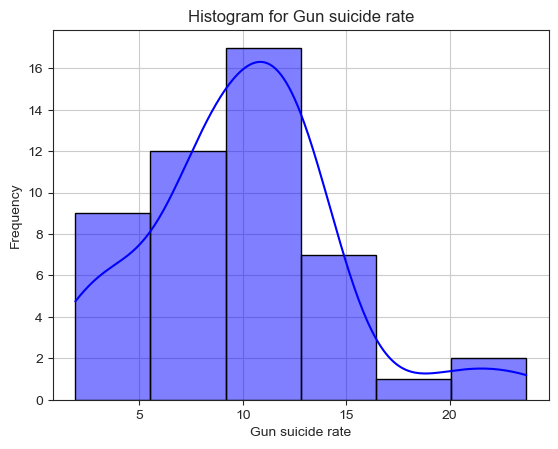

Gun suicide rate


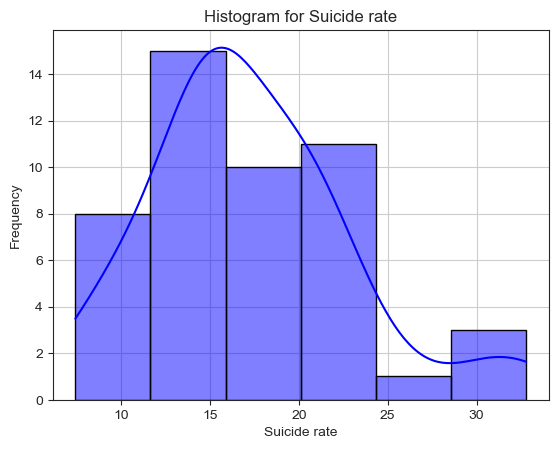

Suicide rate


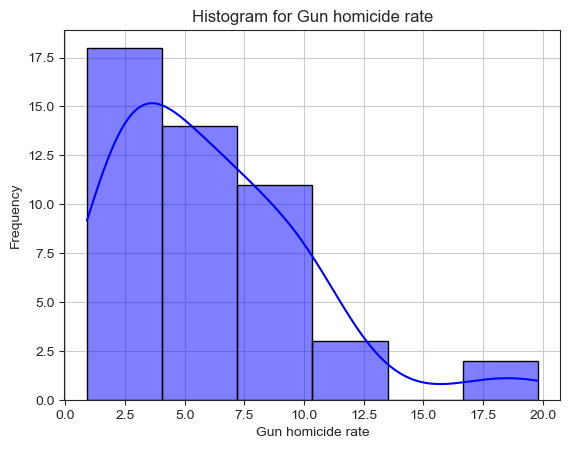

Gun homicide rate


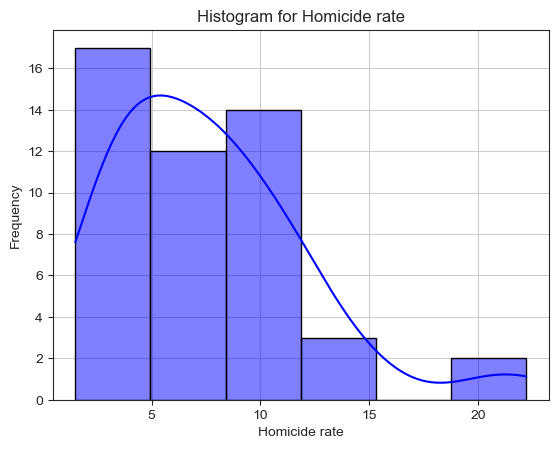

Homicide rate


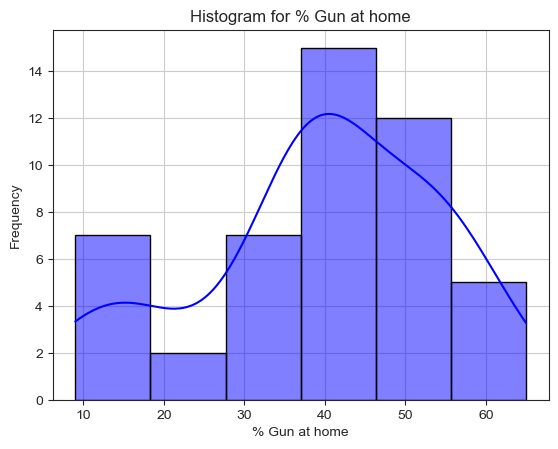

% Gun at home


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sturge's rule for the optimal bin amount is best for small datasets
# https://www.statology.org/sturges-rule/
opt_bin_size = int(np.log2(52)+1)

for col in df_gun.columns[1::]:
    plt.figure()
    sns.histplot(df_gun[col], bins=opt_bin_size, kde=True, color="blue", edgecolor="black")
    plt.title(f"Histogram for {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    print(col)


## 1b)
What is the odds ratio between homicide rate in the USA vs the Netherlands?
You will need to look up and cite where you find the gun homicide rate for
both. Interpret this value. Could you have used the mean from all the states?

The formular for the Odds ratio:

$OR = (A/B)/(C/D)$

A = Gun homicides total NE — 85 [3] <br>
B = Inhabitants NE — 18,300,040 [4]

C = Gun homicides total USA — 20,958[1]<br>
D= Inhabitants USA — 346,543,400 [2]

1. https://en.wikipedia.org/wiki/Gun_violence_in_the_United_States#:~:text=In%202021%2C%20a%20little%20above,the%20highest%20percentage%20since%202001.
2. https://www.worldometers.info/world-population/us-population/
3. https://worldpopulationreview.com/country-rankings/gun-deaths-by-country
4. https://www.worldometers.info/world-population/netherlands-population/#google_vignette




In [61]:
A = 85
B =18300040
C =20958
D =346543400

## we dont subtract the gun homicides here, as they would not make a significant difference from the population
OR = (A/B)/(C/D)

OR

0.07680238075690325

### What does that tell us?

As the OR = 0.0768 that mean 1—OR= 0.923, which can be intepreted as a 92% reduction in risk, but as this alone doesnt tell us a bunch we would also have to take a look at the absolute risks as well the Odds ratio

_*Could we have used the mean from all of the states?*_ <br>
We could have, but as the mean is quite susceptible to outliers this may have skewed the results


## 1c)


In [62]:
df_gun["Gun Homicide odds"] = (df_gun["Gun homicide rate"]/100000)/(1-(df_gun["Gun homicide rate"]/100000))
## for the highest as best ist ambiguous
df_gun_odds = df_gun.sort_values(by='Gun Homicide odds', ascending=False, inplace=False).head()
df_gun_odds

,Location,Gun suicide rate,Suicide rate,Gun homicide rate,Homicide rate,% Gun at home,Gun Homicide odds
21,Mississippi,11.3,16.3,19.8,22.2,54.0,0.000198
27,Louisiana,10.0,14.9,17.4,20.4,52.0,0.000174
12,Alabama,12.4,16.4,12.9,14.8,53.0,0.000129
4,New Mexico,14.4,25.2,10.9,14.5,36.0,0.000109
24,South Carolina,10.5,15.5,10.7,12.6,45.0,0.000107


In [63]:
## for the lowest
df_gun_odds = df_gun.sort_values(by='Gun Homicide odds', ascending=True, inplace=False).head()
df_gun_odds

,Location,Gun suicide rate,Suicide rate,Gun homicide rate,Homicide rate,% Gun at home,Gun Homicide odds
19,Maine,11.5,20.2,0.9,1.5,48.0,0.000009
50,Massachusetts,1.9,8.6,1.4,2.3,9.0,0.000014
6,Idaho,13.8,20.4,1.5,2.2,58.0,0.000015
47,Hawaii,2.9,14.0,1.6,2.7,9.0,0.000016
1,Wyoming,23.7,32.8,1.7,2.8,61.0,0.000017


___
___

## Exercise 2

### 2a)
Generate the mean and standard deviation for the Netherlands for life
expectancy and infant mortality from 2000 to 2015

In [64]:
df_Gap = pd.read_csv("Gapminder_1900-2017_by_yr.csv")
df_ndl = df_Gap[(df_Gap["country"] == "Netherlands") & (df_Gap["year"] >= 2000) & (df_Gap["year"] <= 2015)]

In [65]:
mean_infant = df_ndl["infant.mortality_per1000"].mean()
mean_infant

4.106249999999999

In [66]:
std_infant = df_ndl["infant.mortality_per1000"].std()
std_infant

0.6444312738117748

In [67]:
mean_life_exp = df_ndl["life.expectancy"].mean()
mean_life_exp

79.981875

In [68]:
std_life_exp = df_ndl["life.expectancy"].std()
std_life_exp

1.2077870604263552

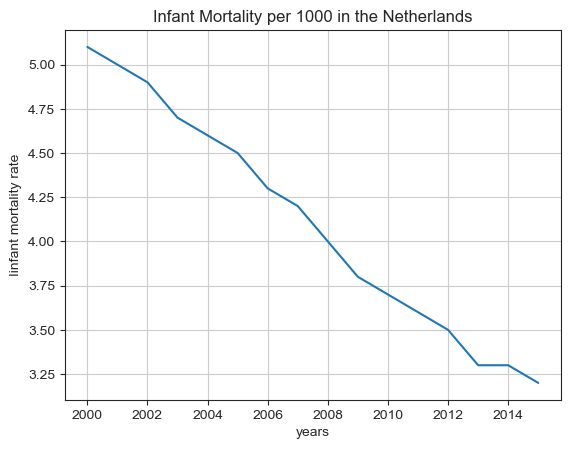

In [69]:
plt.figure()
sns.lineplot(y= df_ndl["infant.mortality_per1000"], x= range(2000,2016) )
plt.title(f"Infant Mortality per 1000 in the Netherlands")
plt.xlabel("years")
plt.ylabel("Iinfant mortality rate")
plt.grid(True)
plt.show()

## 3
### 3a)


In [70]:
df_NH2000 = pd.read_csv("NHANES-2000.csv")
df_NH2000.head()

,SurveyYr,ID,Gender,Age,AgeDecade,AgeMonths,Race1,Race3,Education,MaritalStatus,...,AgeFirstMarij,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation
0,2011_12,63549,female,5,0-9,NaN,Black,Black,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011_12,64871,female,49,40-49,NaN,White,White,CollegeGrad,Married,...,16.0,No,NaN,No,Yes,16.0,25.0,1.0,No,Heterosexual
2,2011_12,70551,male,37,30-39,NaN,White,White,SomeCollege,Married,...,NaN,No,NaN,No,Yes,16.0,10.0,1.0,No,Heterosexual
3,2011_12,66033,female,37,30-39,NaN,White,White,9_11thGrade,Married,...,12.0,Yes,14.0,Yes,Yes,15.0,60.0,1.0,Yes,Heterosexual
4,2011_12,69958,male,12,10-19,NaN,White,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


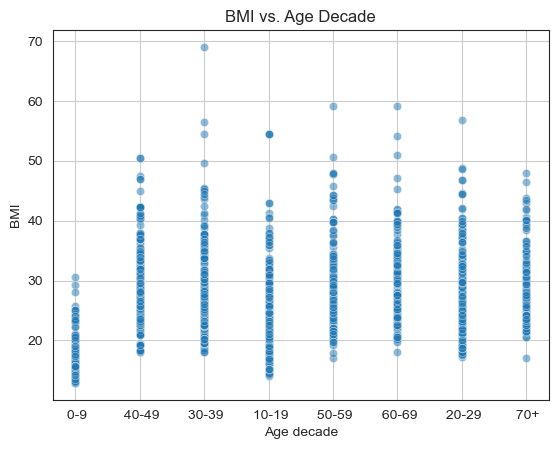

In [71]:
## create scatterplot after requirements
plt.figure()
sns.set_style("white")
sns.scatterplot(y= df_NH2000["BMI"], x= df_NH2000["AgeDecade"], alpha =0.5 )
plt.title(f"BMI vs. Age Decade")
plt.xlabel("Age decade")
plt.ylabel("BMI")
plt.grid(True)
plt.show()

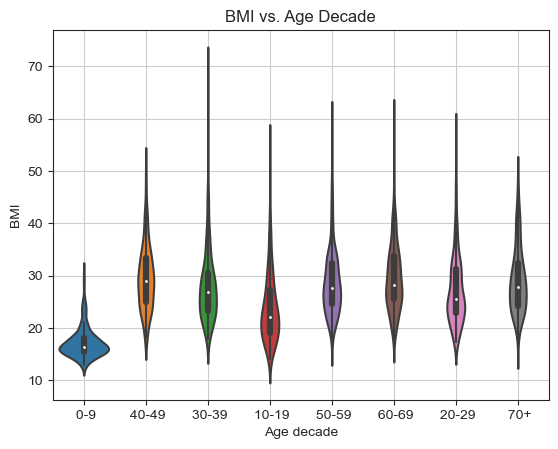

In [72]:
# Violinplot
plt.figure()
sns.set_style("ticks")
sns.violinplot(y= df_NH2000["BMI"], x= df_NH2000["AgeDecade"])
plt.title(f"BMI vs. Age Decade")
plt.xlabel("Age decade")
plt.ylabel("BMI")
plt.grid(True)
plt.show()

## 3b)
   ### i)
I chose HHIncomeMid instead of HHIncome, as to create a plot the values must be numeric and the mid values from the same DS may be the best representation instead of creating a custom method to convert to numeric

In [73]:
## Clean up HHIncome
df_NH2000["HHIncomeMid"].replace("NA", np.nan, inplace=True)


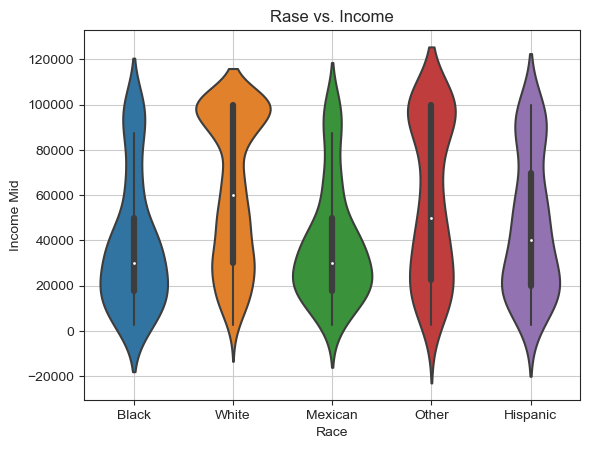

In [74]:
plt.figure()
sns.set_style("ticks")
sns.violinplot(y= df_NH2000["HHIncomeMid"], x= df_NH2000["Race1"])
plt.title(f"Rase vs. Income")
plt.xlabel("Race")
plt.ylabel("Income Mid")
plt.grid(True)
plt.show()

   ### ii)

In [75]:
white_count_total = (df_NH2000["Race1"] == "White").sum()
white_bet_20_25 = ((df_NH2000["Race1"] == "White") & (df_NH2000["HHIncomeMid"] == 22500)).sum()

white_perc_20 =round((white_bet_20_25/white_count_total)*100)

Mexican_count_total = (df_NH2000["Race1"] == "Mexican").sum()
Mexican_bet_20_25 = ((df_NH2000["Race1"] == "Mexican") & (df_NH2000["HHIncomeMid"] == 22500)).sum()

Mexican_perc_20 =round((Mexican_bet_20_25/Mexican_count_total)*100)

print(f" {white_perc_20}% of white people have a HH income between 20-25 \n"
      f"{Mexican_perc_20}% of mexican people have a HH income between 20-25")


 5% of white people have a HH income between 20-25 
12% of mexican people have a HH income between 20-25


In [76]:
white_bet_65_75 = ((df_NH2000["Race1"] == "White") & (df_NH2000["HHIncomeMid"] == 70000)).sum()

white_perc_65_75 =round((white_bet_65_75/white_count_total)*100)

Mexican_bet_65_75 = ((df_NH2000["Race1"] == "Mexican") & (df_NH2000["HHIncomeMid"] == 70000)).sum()

Mexican_perc_65_75 =round((Mexican_bet_65_75/Mexican_count_total)*100)

print(f" {white_perc_65_75}% of white people have a HH income between 65-75 \n"
      f"{Mexican_perc_65_75}% of mexican people have a HH income between 65-75")

 6% of white people have a HH income between 65-75 
5% of mexican people have a HH income between 65-75


## 3d)

I chose the USA and Malaysia. Two countries that i would have never put into one class when it comes ot infant mortality.
One claiming to be the most advanced country on earth and the other one known for its rainforest and it turns out theyre on a very similar level, with Malaysia having the to be expected higher infant mortality in the past but now having a steeper decrease then the US

## 3e)
![3e](3e.png)

## 4
### Creating purposely bad charts

1. Donut Charts make it difficult to derive meaningful insights due to the lack of a baseline and the inability to quickly compare values. As the number of unique categories increases, readability worsens. Even with just five groups, the chart is already approaching its limit.

2. Word Clouds suffer from similar issues as pie charts, making it nearly impossible to determine whether differences are meaningful, relevant, or significant. Longer words may appear more prominent regardless of frequency, distorting interpretation. Additionally, word clouds lack the ability to compare multiple datasets simultaneously, a task better suited to stacked bar charts.

3. Radial Bar Charts hinder comparison as they lack a clear point of reference, making it hard to gauge differences between groups. This issue is exacerbated when categories extend in opposite directions. In the example provided, a dominant category overshadows the others, making it nearly impossible to discern which group is the second most significant or by how much.

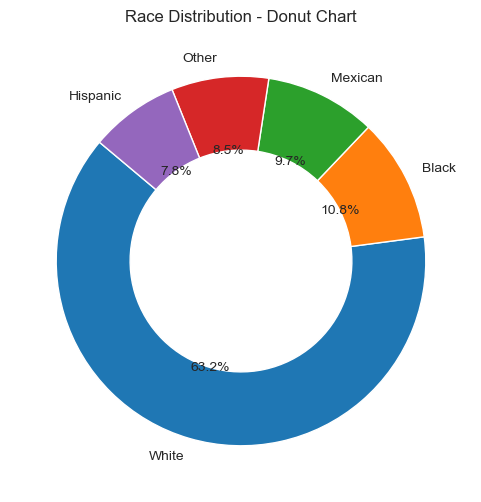

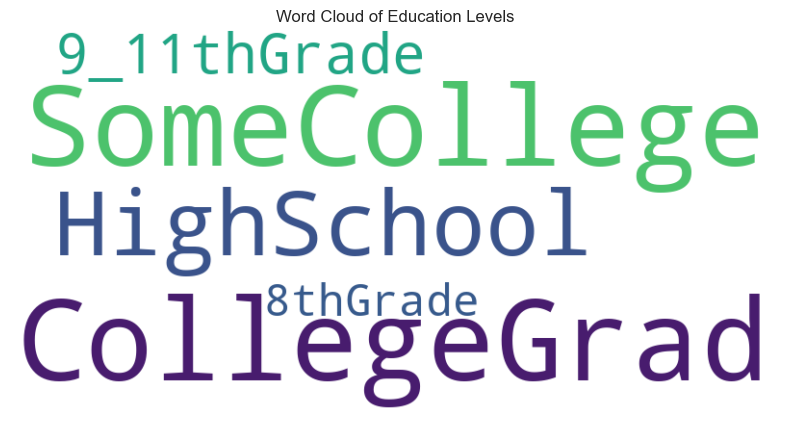

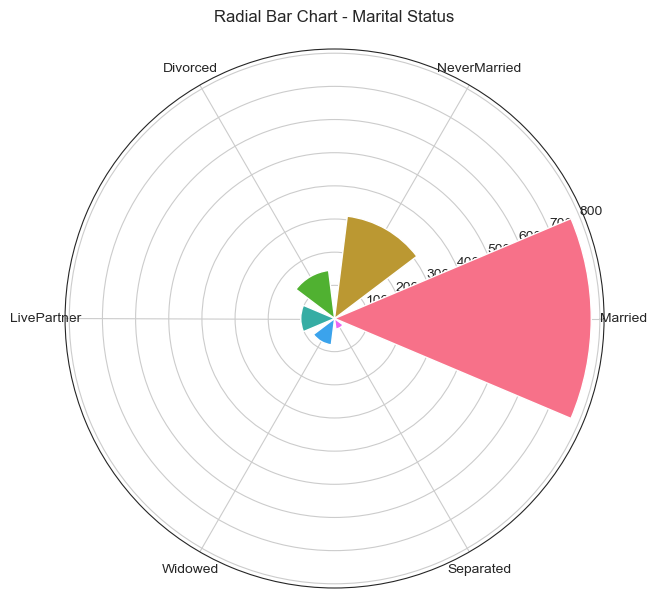

In [77]:
from wordcloud import WordCloud


# Donut Chart - Race Distribution
race_counts = df_NH2000["Race1"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
plt.title("Race Distribution - Donut Chart")
plt.show()

# Word Cloud - Education Levels
edu_text = " ".join(df_NH2000["Education"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(edu_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Education Levels")
plt.show()

# Radial Bar Chart - Marital Status
marital_counts = df_NH2000["MaritalStatus"].value_counts()
angles = np.linspace(0, 2 * np.pi, len(marital_counts), endpoint=False)
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "polar"})
ax.bar(angles, marital_counts, tick_label=marital_counts.index, color=sns.color_palette("husl", len(marital_counts)))
ax.set_title("Radial Bar Chart - Marital Status", pad=20)
plt.show()


## 5)
*What is the data, sample, study population and target population for the following
cases: <br>
a. How is gun violence in the USA changing over time? <br>
b. How can I judge if the birth length of a baby is abnormal?* <br>
for A:

    1. Data: police reports, hospital records, surveys
    2. Sample: well chosen sample locations, that are diverse in the location and socio econmic backgrounds,
            maybe even political affiliaton
    3. study population: all gun violence incidents which were reported or witnessed
    4. target populaton: All gun violence nation wide

for B:

    1. Data: measurements of birth lengths taken in hospitals
    2. Sample: A subset defined by location and time
    3. study population: All kids that were in the study
    4. target populaton: All newborns that fall at least partially in the sample, or have similar conditions ans the kids in the sample

## 6)
Finding nonsensical correlations in the NHANES dataset


In [85]:
## finding something in brute forcing
brute_it = False
if brute_it:
    columns = df_NH2000.columns
    for dependant in columns[2::]:
        for independent in columns[2::]:
            if dependant == independent:
                continue
            plt.figure()
            sns.set_style("ticks")
            sns.lineplot(y= df_NH2000[dependant], x= df_NH2000[independent])
            plt.title(f"Nonsensical correlations")
            plt.xlabel(independent)
            plt.ylabel(dependant)
            plt.grid(True)
            plt.show()

NHANES-2000 turns out to be a bad place to find nonsensical correlations, as it represents a data set of Health-related topics (e.g. Diabetes, depression, and BMI) and comparing these to other facts of life as in the sexual orientation, age, race, height and income groups would very unlikely give und nonsensical correlations and in a complex system as our bodies nonsensical correlations are incredibly hard to discern from sensical ones without proper training and expertise. I will also take a different approach and focus more on the actual correlation itself rather than its visual representation
<br>
<br>
*finding nonsensical correlations in the Gapminder-1900-2017_by_yr dataset*:

In [119]:
## getting only numeric data:
numeric_data = df_Gap.select_dtypes(include="number")
columns = numeric_data.columns

high_corr_pairs = []
threshold = 0.8

for dependant in columns:
    for independent in columns:
        if dependant == independent:
            continue
        corr_value = df_Gap[dependant].corr(df_Gap[independent])
        if abs(corr_value) > threshold:
            high_corr_pairs.append((dependant, independent, corr_value))

high_corr_pairs


[('year', 'life.expectancy', 0.8208799326273566),
 ('age_median', 'children.per.woman', -0.8376131397046571),
 ('age_median', 'income.below.550.a.day', -0.82563592580735),
 ('bmi_female', 'bmi_male', 0.8783387029679232),
 ('bmi_male', 'bmi_female', 0.8783387029679232),
 ('cellphones_per100', 'internet.users_percent', 0.8156110360739622),
 ('children.per.woman', 'age_median', -0.8376131397046571),
 ('co2.emissions_in1000tonnes', 'gdp.percap_ppp.adj', 0.9112378226565184),
 ('co2.emissions_percap', 'energy.use_percap', 0.874675786399807),
 ('corruption.index_pre2012meth', 'gdp.percap_usd', 0.8171596403969229),
 ('education_ratio.boys.to.girls',
  'youth.literacy.rate_pc',
  0.8353989582982777),
 ('energy.use_percap', 'co2.emissions_percap', 0.874675786399807),
 ('gdp.percap_ppp.adj', 'co2.emissions_in1000tonnes', 0.9112378226565185),
 ('gdp.percap_usd', 'corruption.index_pre2012meth', 0.8171596403969229),
 ('gdp.percap_usd', 'health.spend_per.person', 0.8881908955439941),
 ('gdp.percap_us

There are a few interesting correlations in here, but the most are to be expected!


In [127]:
numeric_data = df_school.select_dtypes(include="number")
columns = numeric_data.columns

high_corr_pairs = []
threshold = 0.8

for dependant in columns:
    for independent in columns:
        if dependant == independent:
            continue
        corr_value = df_school[dependant].corr(df_school[independent])
        if abs(corr_value) > threshold:
            high_corr_pairs.append((dependant, independent, corr_value))

high_corr_pairs


[('age', 'year', 0.9227050147323741), ('year', 'age', 0.9227050147323741)]

There isn't anything nonsensical in here that is highly correlated that isnt obvious

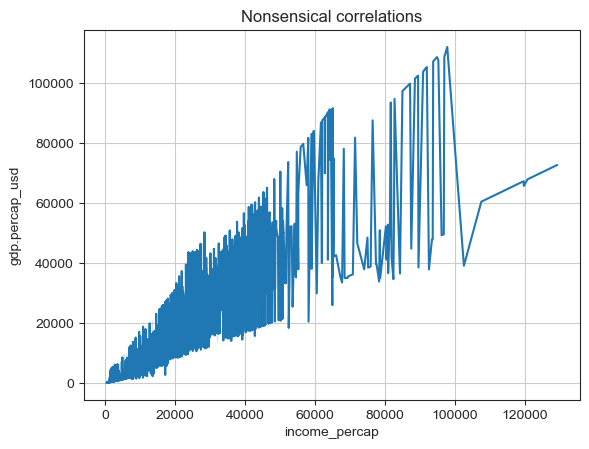

0.9027
0.8083


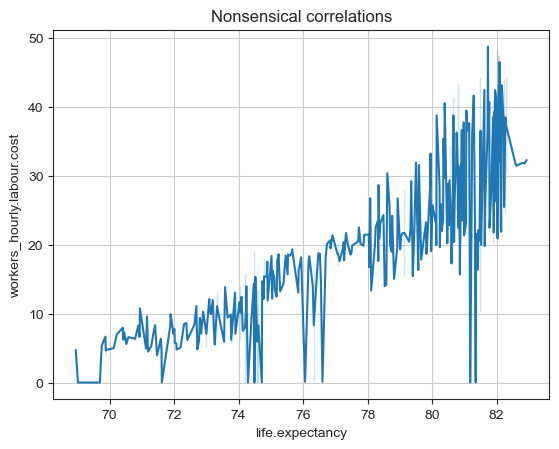

In [132]:
## The highlights of what I found

plt.figure()
sns.lineplot(y= df_Gap["gdp.percap_usd"], x= df_Gap["income_percap"])
plt.title(f"Nonsensical correlations")
plt.grid(True)
plt.show()
correlation = df_Gap["gdp.percap_usd"].corr(df_Gap["income_percap"])
print(round(correlation, 4))

plt.figure()
sns.lineplot(y= df_Gap["workers_hourly.labour.cost"], x= df_Gap["life.expectancy"])
plt.title(f"Nonsensical correlations")
correlation = df_Gap["workers_hourly.labour.cost"].corr(df_Gap["life.expectancy"])
print(round(correlation, 4))

plt.grid(True)
plt.show()


### Possible lurking factors to consider
Plot 1: For the first plot I would expect a correlation of very close to 1, as the gdp per capita as well as the income per capita measure a very similar metric. This difference could maybe be due to money that is inherited and not being worked for.

<br>
Plot 2: The hourly pay can have some influence in the life expectancy, but not as much i believe it also shouldn't have these seemingly random dips in the graph. The underlying connecting factor could be access to healthcare and education